# Testing William fractal strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import ta, pickle, json, time

# Import

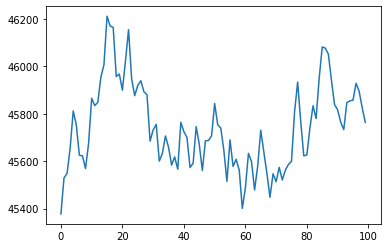

In [182]:
df = pd.read_csv("../data/train.csv")
df = pd.read_csv("../data/test.csv")
plt.plot(df.open[:100])

In [183]:
def wilFractal(df):
        bear = (
                df['high'].shift(2).lt(df['high']) &
                df['high'].shift(1).lt(df['high']) &
                df['high'].shift(-1).lt(df['high']) &
                df['high'].shift(-2).lt(df['high'])
        )
    
        bull = (
                df['low'].shift(2).gt(df['low']) &
                df['low'].shift(1).gt(df['low']) &
                df['low'].shift(-1).gt(df['low']) &
                df['low'].shift(-2).gt(df['high'])
        )
    
        return bear, bull
    
def ema(df, windows=[20]):
    emas = []
    for x in windows:
        emas.append(
            ta.trend.ema_indicator(close=df.close, window=x, fillna=True)
        )
    return emas

In [184]:
df['bear'], df['bull'] = wilFractal(df)
df['ema20'], df['ema50'], df['ema100'] = ema(df, [20, 50, 100])
df

,timestamp,open,high,low,close,volume,bear,bull,ema20,ema50,ema100
0,2021-05-16 22:02:00,45377.19,45539.00,45377.19,45530.62,130.561983,False,False,45530.620000,45530.620000,45530.620000
1,2021-05-16 22:03:00,45528.98,45581.65,45430.65,45548.49,182.492948,False,False,45532.321905,45531.320784,45530.973861
2,2021-05-16 22:04:00,45548.49,45709.11,45522.11,45654.36,151.296726,False,False,45543.944580,45536.145852,45533.417151
3,2021-05-16 22:05:00,45654.36,45878.14,45650.00,45812.14,213.061258,True,False,45569.487001,45546.969152,45538.936416
4,2021-05-16 22:06:00,45812.14,45812.15,45654.85,45763.92,146.018679,False,False,45588.004430,45555.477028,45543.391536
...,...,...,...,...,...,...,...,...,...,...,...
8636,2021-05-22 21:58:00,38050.71,38139.78,38028.71,38137.65,31.582959,False,False,38078.383502,38030.833325,37970.078520
8637,2021-05-22 21:59:00,38137.66,38172.95,38086.52,38153.77,34.298543,False,False,38085.563169,38035.654371,37973.715975
8638,2021-05-22 22:00:00,38153.91,38300.00,38153.77,38287.57,84.791436,False,False,38104.801915,38045.533416,37979.930906
8639,2021-05-22 22:01:00,38287.58,38304.99,38218.06,38236.11,69.558038,False,False,38117.307447,38053.007007,37985.003759


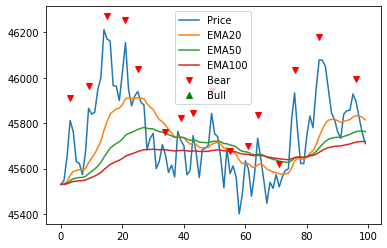

In [185]:
plt.plot(df.close[:100], label='Price')
plt.plot(df.ema20[:100], label='EMA20')
plt.plot(df.ema50[:100], label='EMA50')
plt.plot(df.ema100[:100], label='EMA100')
plt.plot(np.array(range(100))[df.bear[:100]], df.close[:100][df.bear[:100]] + 100, 
         "vr", label='Bear')
plt.plot(np.array(range(100))[df.bull[:100]], df.close[:100][df.bull[:100]] - 100, 
         "^g", label='Bull')
plt.legend()

# Trading

In [186]:
def trade(df, low, high, start):
    ls = df.values.tolist()
    n = len(ls)
    for i in range(n):
        if ls[i][0] > high: # test high
            return high, i
        if ls[i][1] < low: # test low
            return low, i
    return start, n

In [187]:
trades = pd.DataFrame(columns=["i", "timestamp", "Action", "Start", "End", "Benef", "Duration"])
for i in range(len(df)):
    timestamp, o, h, l, c, v, bear, bull, ema20, ema50, ema100 = df.iloc[i]
    if ema20 < ema50 < ema100: # SELL only
        if bear:
            trigger = False
            if ema50 < h < ema100:
                trigger = True
                SL = ema100
            if ema20 < h < ema50:
                trigger = True
                SL = ema50
            if trigger:
                start = df.close[i+2]
                TP = start - 1.5 * (SL - start)
                end, n = trade(df[['high', 'low']][i+2:i+122], TP, SL, start)
                trades = trades.append({
                    "i": i+2,
                    "timestamp" : timestamp,
                    "Action" : "SELL",
                    "Start" : start,
                    "End" : end,
                    "Benef" : start-end,
                    "Duration" : n
                }, ignore_index=True)
    
    if ema20 > ema50 > ema100: # BUY only
        if bull:
            trigger = False
            if ema50 > l > ema100:
                trigger = True
                SL = ema100
            if ema20 > h > ema50:
                trigger = True
                SL = ema50
            if trigger:
                start = df.close[i+2]
                TP = start + 1.5 * (start - SL)
                end, n = trade(df[['high', 'low']][i+2:i+122], SL, TP, start)
                trades = trades.append({
                    "i": i+2,
                    "timestamp" : timestamp,
                    "Action" : "BUY",
                    "Start" : start,
                    "End" : end,
                    "Benef" : end-start,
                    "Duration" : n
                }, ignore_index=True)

In [188]:
sum(trades.Action == "BUY")

23

In [189]:
trades.mean()

i            4046.625455
Start       40700.931636
End         40656.685219
Benef          47.640067
Duration       16.040000
dtype: float64

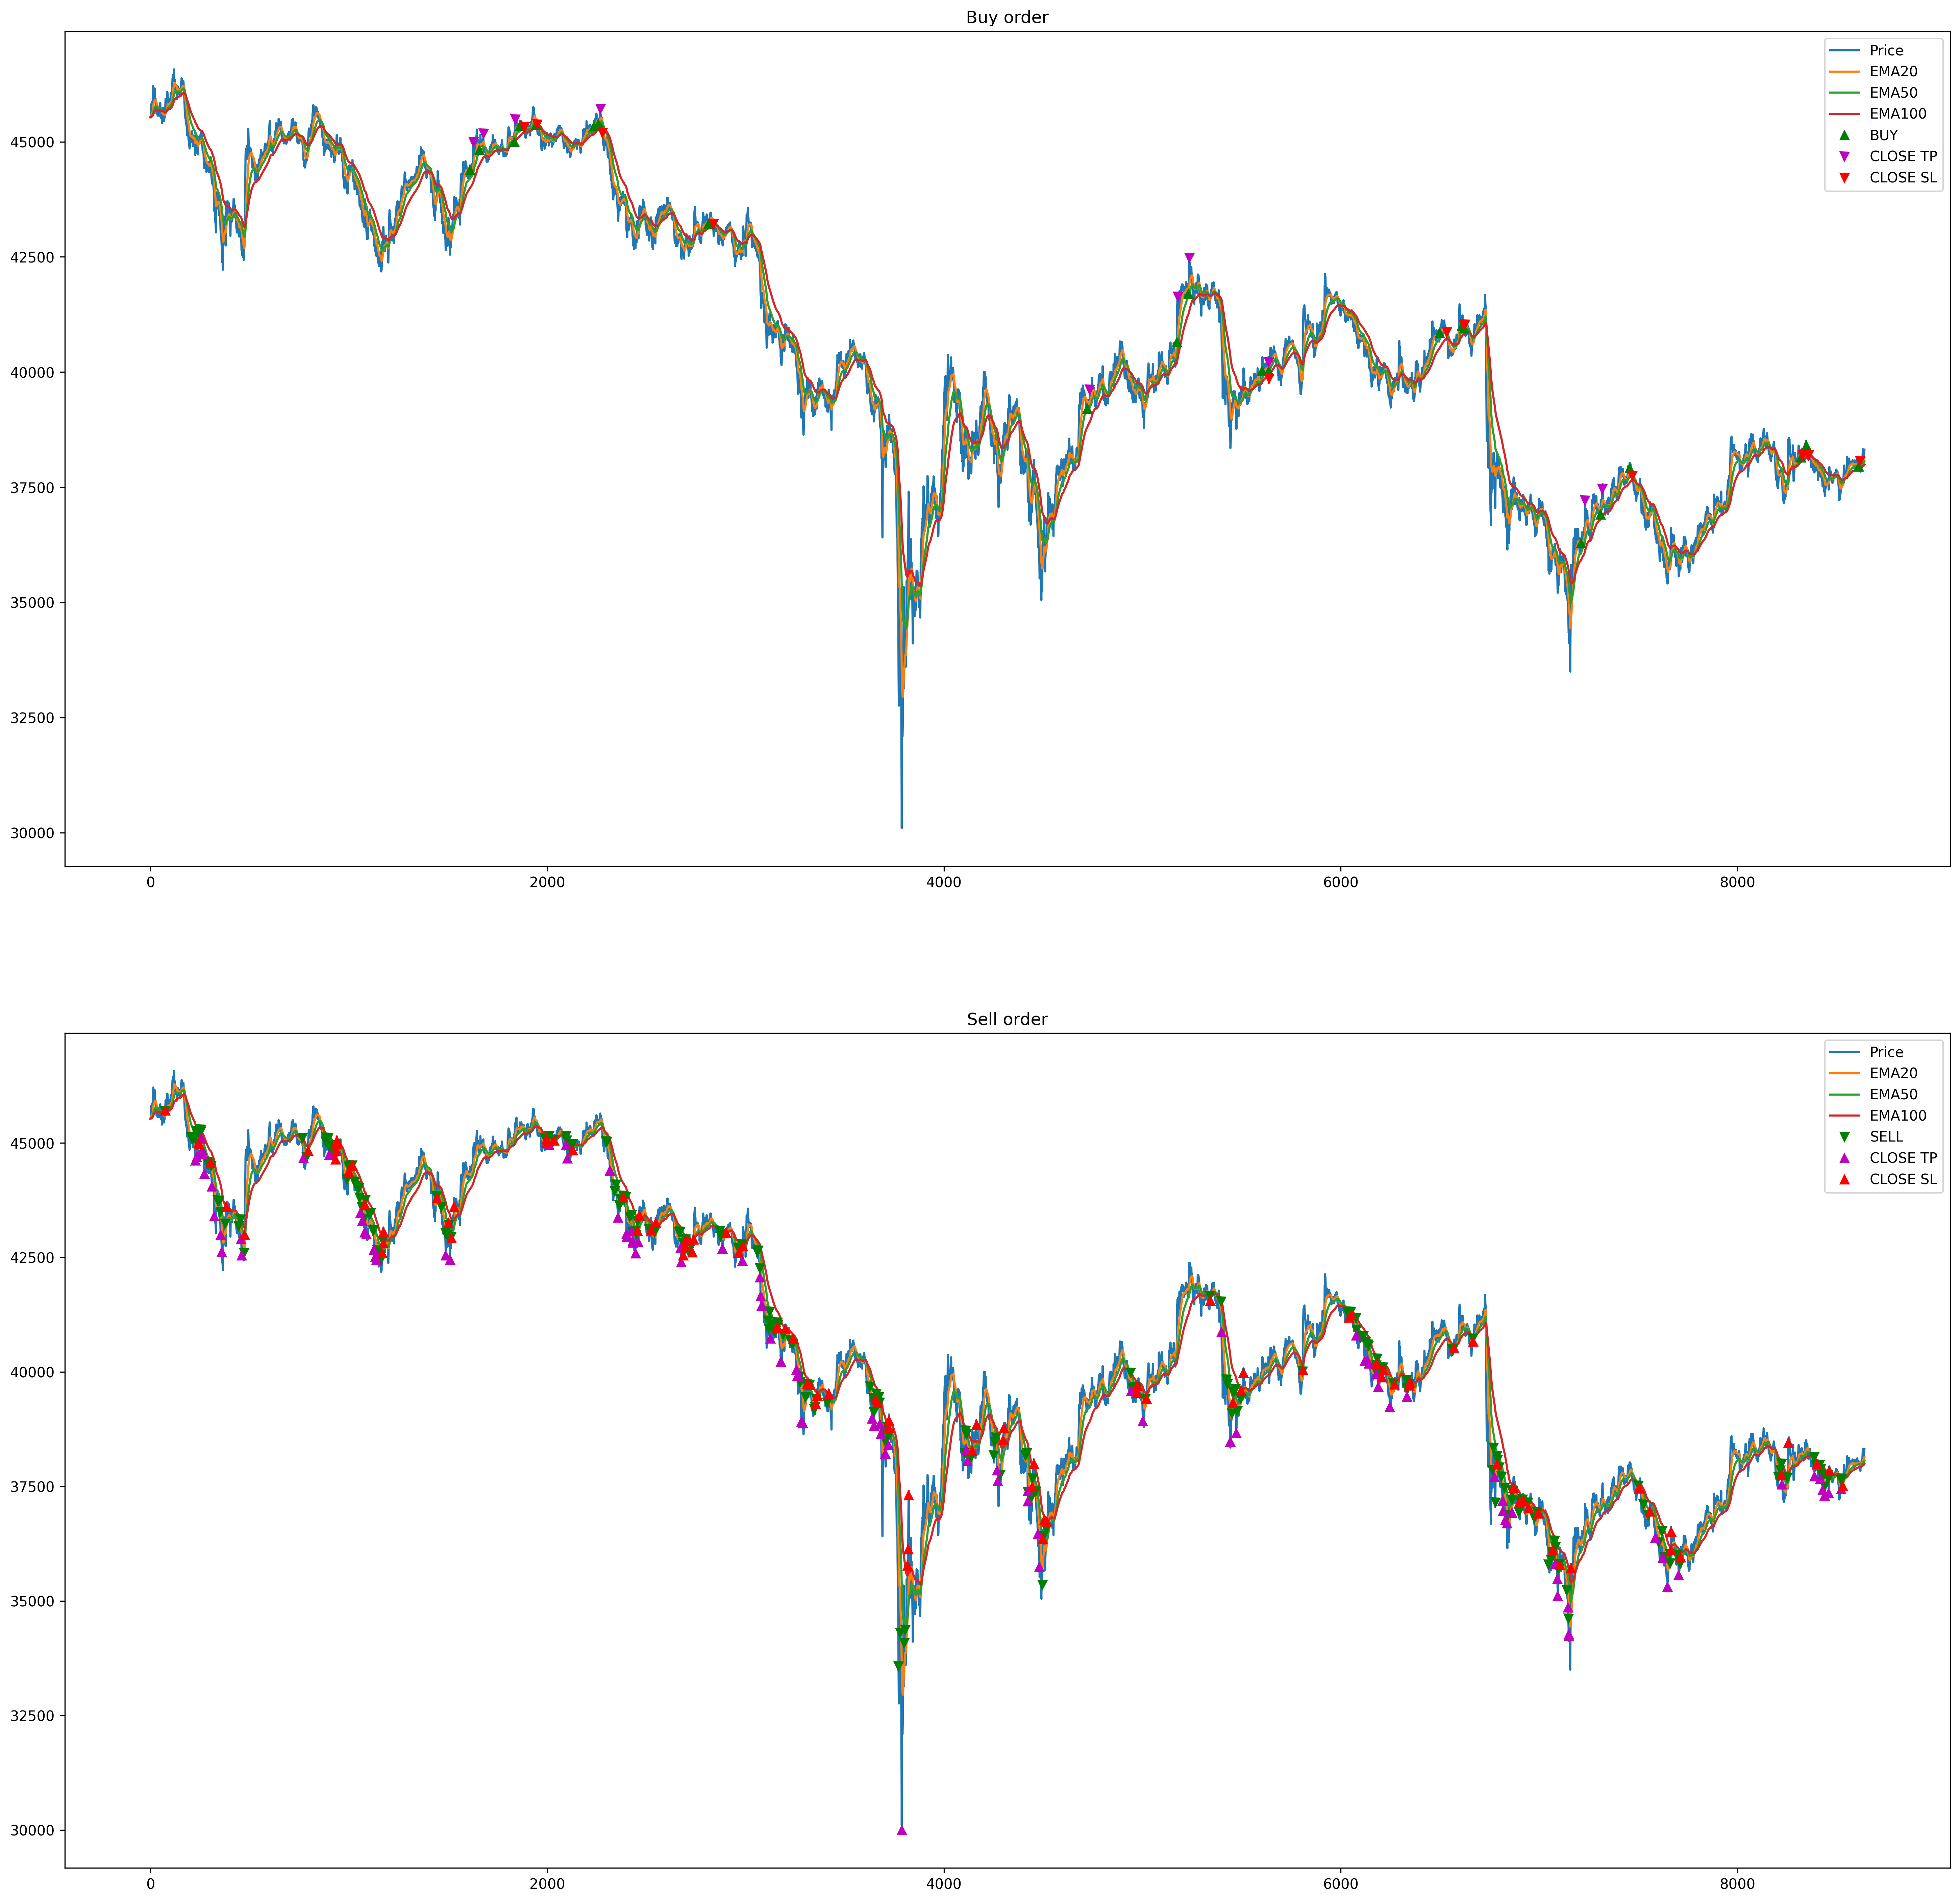

In [190]:
fig, axs = plt.subplots(2, 1, figsize=(24, 24), dpi=300)

# Plotting prices Buy
ax = axs[0]
ax.plot(df.close, label='Price')
ax.plot(df.ema20, label='EMA20')
ax.plot(df.ema50, label='EMA50')
ax.plot(df.ema100, label='EMA100')
# data
buy = (trades.Action == "BUY")
buy_win = (trades.Action == "BUY") & (trades.Benef > 0)
buy_lose = (trades.Action == "BUY") & (trades.Benef < 0)
ax.plot(trades[buy].i, 
        df.close.iloc[trades[buy].i] - 100, 
        "^g", label='BUY')
ax.plot(trades[buy_win].i + trades[buy_win].Duration, 
        df.close.iloc[trades[buy_win].i + trades[buy_win].Duration] + 100, 
        "vm", label='CLOSE TP')
ax.plot(trades[buy_lose].i + trades[buy_lose].Duration, 
        df.close.iloc[trades[buy_lose].i + trades[buy_lose].Duration] + 100, 
         "vr", label='CLOSE SL')
ax.set_title("Buy order")
ax.legend()

# Plotting prices Sell
ax = axs[1]
ax.plot(df.close, label='Price')
ax.plot(df.ema20, label='EMA20')
ax.plot(df.ema50, label='EMA50')
ax.plot(df.ema100, label='EMA100')
# data
sell = (trades.Action == "SELL")
sell_win = (trades.Action == "SELL") & (trades.Benef > 0)
sell_lose = (trades.Action == "SELL") & (trades.Benef < 0)
ax.plot(trades[sell].i, 
        df.close.iloc[trades[sell].i] + 100, 
        "vg", label='SELL')
ax.plot(trades[sell_win].i + trades[sell_win].Duration, 
        df.close.iloc[trades[sell_win].i + trades[sell_win].Duration] - 100, 
        "^m", label='CLOSE TP')
ax.plot(trades[sell_lose].i + trades[sell_lose].Duration, 
        df.close.iloc[trades[sell_lose].i + trades[sell_lose].Duration] - 100, 
        "^r", label='CLOSE SL')
ax.set_title("Sell order")
ax.legend()

In [179]:
(trades.Action == "BUY") | (trades.Benef > 0)

0     False
1      True
2      True
3      True
4     False
      ...  
56    False
57     True
58     True
59    False
60    False
Length: 61, dtype: bool

In [177]:
(trades.Benef > 0)

0     False
1      True
2      True
3      True
4     False
      ...  
56    False
57     True
58     True
59    False
60    False
Name: Benef, Length: 61, dtype: bool

In [178]:
(trades.Action == "BUY")

0     False
1     False
2     False
3     False
4     False
      ...  
56    False
57    False
58    False
59    False
60    False
Name: Action, Length: 61, dtype: bool